# Twitter sentiment analysis with Logistic Regression and XGBoost
In this notebook I present a simple regression modeling of the sentiment analysis of a database of tweets related to specific companies. This is structured as follows:

1. Initial data transformation
2. Plotting features
3. Text analysis
4. Logistic Regression model
5. XGBoost model
6. Final Remarks

The main objective is to present a simple NLP project and to practice the main uses of libraries such as `wordcloud`,`sklearn`, `nltk` and `re`.

# 1. Initial data transformation

As an initial approach, all the main libraries and functions were summarized in the following cell, focusing on data visualization, text analysis, text vectorization, and model building.

Additionally, the stopwords from English were downloaded from the `nltk` library.

In [104]:
!pip install wordcloud
!pip install nltk

In [105]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os #File location
from wordcloud import WordCloud #Word visualization
import matplotlib.pyplot as plt #Plotting properties
import seaborn as sns #Plotting properties
from sklearn.feature_extraction.text import CountVectorizer #Data transformation
from sklearn.model_selection import train_test_split #Data testing
from sklearn.linear_model import LogisticRegression #Prediction Model
from sklearn.metrics import accuracy_score #Comparison between real and predicted
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder #Variable encoding and decoding for XGBoost
import re #Regular expressions
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /home/ediss6/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ediss6/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
if not os.path.exists('../data/processed_data.csv'):
    
    df_raw = pd.read_csv('../data/Sentiment140.tenPercent.sample.tweets.tsv', sep='\t')
    
    def preprocess_text(text):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove TAGs
        text = re.sub(r'@\w+', '', text)

        # Remove abbreviations
        text = re.sub(r'\b\'ll\b', ' will', text)
        text = re.sub(r'\b\'s\b', ' is', text)
        text = re.sub(r'\b\'re\b', ' are', text)
        text = re.sub(r'\b\'d\b', ' would', text)
        text = re.sub(r'\b\'m\b', ' am', text)
        text = re.sub(r'\b\'ve\b', ' have', text)
        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Replace more than one space with a single space
        text = re.sub(r'\s+', ' ', text)
        # Trim text with space before and after
        text = text.strip()
        # Convert to lowercase
        text = text.lower()
        return text

    def preprocess_wrapper(args):
        index, row = args
        row['tweet_text_processed'] = preprocess_text(row['tweet_text'])
        return row

    # Apply preprocess_text() to each row using multiprocessing
    num_processes = cpu_count()  # Number of CPU cores
    print(f'{num_processes} cores are using to process the data for accelerating processing time.')

    with Pool(processes=num_processes) as pool:
        result = list(tqdm(pool.imap(preprocess_wrapper, df_raw.iterrows()), total=len(df_raw)))

    # Convert the list of processed rows back to a DataFrame
    df = pd.DataFrame(result)
    df.to_csv('../data/processed_data.csv', index=False)
else:
    df =  pd.read_csv('../data/processed_data.csv')
    
df.dropna(subset=['tweet_text_processed'], inplace=True)

In [107]:
# Splitting into train and test sets (80-20 split)
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)
train_data

,sentiment_label,tweet_text,tweet_text_processed
148362,0,"DaveTaylor: Oh, and really bummed that is bec...",davetaylor oh and really bummed that is becomi...
136142,4,"@JiaYiing-If i'm not wrong,he hasn't got his E...",if i am not wronghe hasnt got his english pape...
128316,0,Going to GCA soon to check some work then back...,going to gca soon to check some work then back...
79577,0,Going to the doctors for a shot sooo tired...,going to the doctors for a shot sooo tired
40642,0,Jesus fuck! All the gay guys at the bar aree s...,jesus fuck all the gay guys at the bar aree so...
...,...,...,...
120142,4,-- DT tonight; DT tomorrow day &amp; night b...,dt tonight dt tomorrow day amp night beauty
103924,0,i have a singaw,i have a singaw
132206,0,@KatiesKreations same prob stuck at 2001 can't...,same prob stuck at cant follow not even follow...
147185,4,@jaykpurdy Well I didn't spell your name wrong...,well i didnt spell your name wrong evercuz i c...


# 2. Plotting features


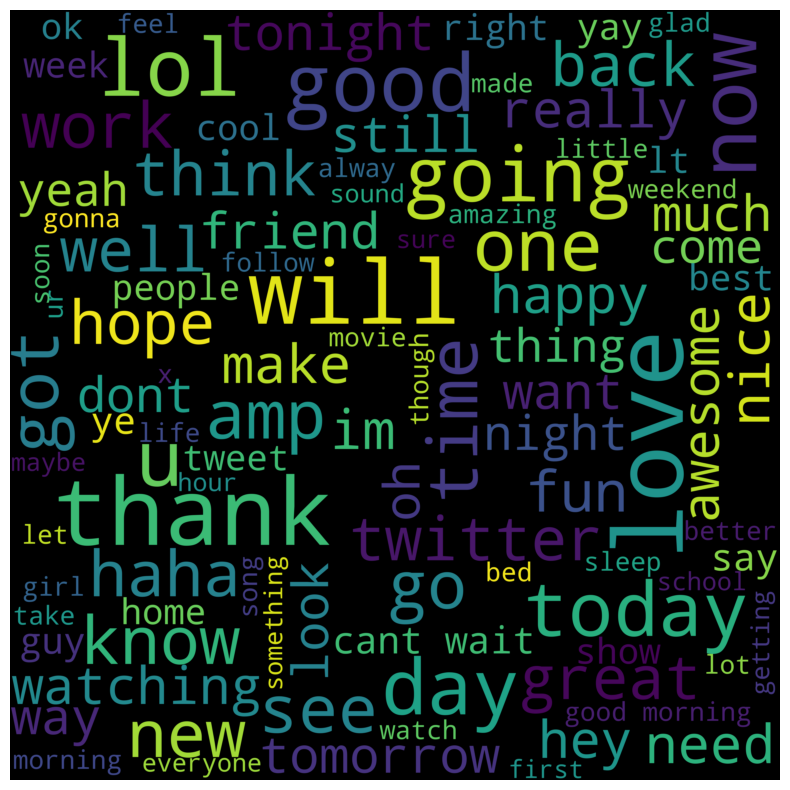

In [108]:
positive_tweets = train_data[train_data["sentiment_label"] == 4]['tweet_text_processed'].astype(str)

# Joining all positive tweets into a single string without spaces
word_cloud_text = ' '.join(positive_tweets)

#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

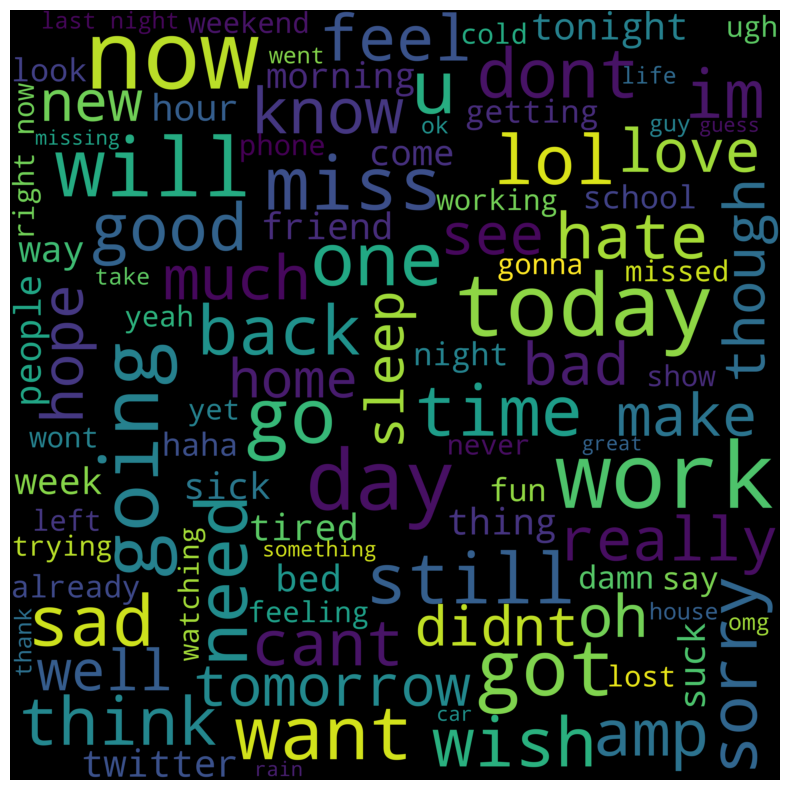

In [109]:
negative_tweets = train_data[train_data["sentiment_label"] == 0]['tweet_text_processed'].astype(str)

# Joining all positive tweets into a single string without spaces
word_cloud_text = ' '.join(negative_tweets)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Text analysis

With the clean text, the initial number of unique tokens was counted to identify the model complexity. As presented, there are more than 70 thousand unique words.

In [110]:
#Text splitting
tokens_text = [word_tokenize(str(word)) for word in train_data.tweet_text_processed]
#Unique word counter
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

Number of tokens:  74922


Also, the main English stopwords were saved on an additional variable, to be used in the following modeling.

In [112]:
#Choosing english stopwords
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

# 4. Logistic Regression model

For the main regression model, it was used a simple Logistic Regression of the sklearn library alongside the Bag of Words (BoW) approach. This last method helps to classify and group the relevant data to help the model identify the proper trends.

On this first BoW, the stopwords were considered alongside a default [ngram](https://deepai.org/machine-learning-glossary-and-terms/n-gram) of 1.

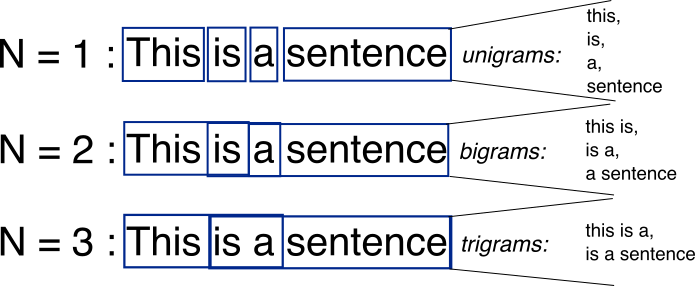

In [113]:
#Initial Bag of Words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words, #English Stopwords
    ngram_range=(1, 1) #analysis of one word
)

Then, the main data was split on train and test datasets alongside the encoding of the words by using the training dataset as a reference:

In [114]:
#Train - Test splitting
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=0)

In [115]:
#Creation of encoding related to train dataset
X_train_bow = bow_counts.fit_transform(train_data.tweet_text_processed)
#Transformation of test dataset with train encoding
X_test_bow = bow_counts.transform(test_data.tweet_text_processed)

/ediss_data/ediss6/ali/miniconda3/envs/pytorch-CycleGAN-and-pix2pix/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/ediss_data/ediss6/ali/miniconda3/envs/pytorch-CycleGAN-and-pix2pix/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [117]:
#Labels for train and test encoding
y_train_bow = train_data.sentiment_label
y_test_bow = test_data.sentiment_label

In [118]:
y_test_bow.value_counts() / y_test_bow.shape[0]

sentiment_label
0    0.502133
4    0.497867
Name: count, dtype: float64

In [119]:
# Logistic regression
model1 = LogisticRegression(C=1, solver="liblinear",max_iter=200)
model1.fit(X_train_bow, y_train_bow)
# Prediction
test_pred = model1.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred) * 100)

Accuracy:  75.84263065179096


In [120]:
#Validation data
X_val_bow = bow_counts.transform(val_data.tweet_text_processed)
y_val_bow = val_data.sentiment_label

In [122]:
Val_res = model1.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow, Val_res) * 100)

Accuracy:  76.42416460492937


Finally, another Bag of Words was used. This had an n-gram of 4 while not classifying the stopwords, using all the available information.

In [123]:
#n-gram of 4 words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)
#Data labeling
X_train_bow = bow_counts.fit_transform(train_data.tweet_text_processed)
X_test_bow = bow_counts.transform(test_data.tweet_text_processed)
X_val_bow = bow_counts.transform(val_data.tweet_text_processed)

/ediss_data/ediss6/ali/miniconda3/envs/pytorch-CycleGAN-and-pix2pix/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [125]:
model2 = LogisticRegression(C=0.9, solver="liblinear",max_iter=1500)
# Logistic regression
model2.fit(X_train_bow, y_train_bow)
# Prediction
test_pred_2 = model2.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_2) * 100)

Accuracy:  79.58504599725974


In [126]:
y_val_bow = val_data.sentiment_label
Val_pred_2 = model2.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow, Val_pred_2) * 100)

Accuracy:  79.95051830509536


# XGBoost approach


In [127]:
le = LabelEncoder()
y_train_bow_num = le.fit_transform(y_train_bow)
y_test_bow_num=le.transform(y_test_bow)
y_val_bow_num=le.transform(y_val_bow)

In [128]:
%%time
XGB=XGBClassifier(objective="multi:softmax",n_estimators=1000,colsample_bytree=0.6, subsample=0.6, num_class=2)
XGB.fit(X_train_bow, y_train_bow_num)
# Prediction
test_pred_2 = XGB.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow_num, test_pred_2) * 100)

Accuracy:  79.15834801330985
CPU times: user 3h 59min 46s, sys: 35.8 s, total: 4h 22s
Wall time: 11min 43s


In [129]:
y_val_bow = val_data.sentiment_label
Val_pred_2 = XGB.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow_num, Val_pred_2) * 100)

Accuracy:  79.42125207478625


At a first glance, with the default XGBoost parameters, the model gets a worse accuracy. For this reason, an additional cell was added to see the training performance:

In [130]:
test_pred_N = XGB.predict(X_train_bow)
print("Accuracy: ", accuracy_score(y_train_bow_num, test_pred_N) * 100)

Accuracy:  86.72401812540983


It was found that the accuracy is the lowest of all the modeling, so parameter tuning is required to improve the overall performance.